In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil

drive_data_path = '/content/drive/MyDrive/dynamic_res/imagenette2'
local_data_path = '/content/imagenette2'

if os.path.exists(local_data_path):
    shutil.rmtree(local_data_path)

shutil.copytree(drive_data_path, local_data_path)
data_path = local_data_path

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
from collections import defaultdict

import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

IMAGENETTE_CLASSES = {
    'n01440764': 'tench',
    'n02102040': 'English springer',
    'n02979186': 'cassette player',
    'n03000684': 'chain saw',
    'n03028079': 'church',
    'n03394916': 'French horn',
    'n03417042': 'garbage truck',
    'n03425413': 'gas pump',
    'n03445777': 'golf ball',
    'n03888257': 'parachute'
}

def get_readable_class_name(folder_name):
    return IMAGENETTE_CLASSES.get(folder_name, folder_name)

def compute_resolution_schedule(r_max, r_min, gamma):
    schedule = []
    r = r_max

    while True:
        schedule.append(r)
        r_next = int(r * gamma)
        r_next = max(r_next, r_min)

        if r_next == r:
            break

        r = r_next

    return schedule

def compute_inverted_resolution_schedule(r_start, r_max, gamma):
    schedule = []
    r = r_start

    while True:
        schedule.append(r)
        r_next = int(r * gamma)
        r_next = min(r_next, r_max)

        if r_next == r:
            break

        r = r_next

    return schedule

def evaluate_predictions_and_losses(model, dataset, device, batch_size=128):
    model.eval()
    sample_data = {}
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    class IndexedDataset(torch.utils.data.Dataset):
        def __init__(self, base_dataset, transform):
            self.base_dataset = base_dataset
            self.transform = transform

        def __len__(self):
            return len(self.base_dataset)

        def __getitem__(self, idx):
            img, target = self.base_dataset.samples[idx]
            img = self.base_dataset.loader(img)
            img = self.transform(img)

            return img, target, idx

    transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), normalize])
    indexed_dataset = IndexedDataset(dataset, transform)
    loader = DataLoader(indexed_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    criterion = nn.CrossEntropyLoss(reduction='none')

    with torch.no_grad():
        for images, targets, indices in loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            outputs = model(images)
            losses = criterion(outputs, targets)
            _, predicted = outputs.max(1)

            for idx, loss, pred, target in zip(indices.cpu().numpy(), losses.cpu().numpy(), predicted.cpu().numpy(), targets.cpu().numpy()):
                sample_data[idx] = {'loss': loss, 'prediction': pred, 'target': target, 'correct': (pred == target)}

    return sample_data

def reconstruct_resolution_assignments(sample_losses, num_samples, ratio_schedule, reassign_epoch, total_epochs, mode='dynamic'):
    sample_resolutions = {i: 0 for i in range(num_samples)}
    sorted_samples = sorted(sample_losses.items(), key=lambda x: x[1])
    reassignment_count = 0

    for epoch in range(total_epochs):
        if (epoch + 1) % reassign_epoch == 0 and epoch >= reassign_epoch - 1:
            current_ratio = ratio_schedule[min(reassignment_count, len(ratio_schedule) - 1)]
            num_to_change = int(len(sorted_samples) * current_ratio)

            if mode == 'dynamic':
                samples_to_change = [idx for idx, _ in sorted_samples[:num_to_change]]
            else:
                samples_to_change = [idx for idx, _ in sorted_samples[-num_to_change:]]

            for idx in samples_to_change:
                sample_resolutions[idx] += 1
            reassignment_count += 1

    return sample_resolutions

def analyze_resolution_correctness(sample_resolutions, sample_correctness, mode='dynamic'):
    changed_samples = [idx for idx, res_level in sample_resolutions.items() if res_level > 0]
    unchanged_samples = [idx for idx, res_level in sample_resolutions.items() if res_level == 0]

    changed_correct = sum(1 for idx in changed_samples if sample_correctness[idx])
    changed_incorrect = sum(1 for idx in changed_samples if not sample_correctness[idx])
    unchanged_correct = sum(1 for idx in unchanged_samples if sample_correctness[idx])
    unchanged_incorrect = sum(1 for idx in unchanged_samples if not sample_correctness[idx])

    total_changed = len(changed_samples)
    total_unchanged = len(unchanged_samples)

    changed_correct_pct = (changed_correct / total_changed * 100) if total_changed > 0 else 0
    changed_incorrect_pct = (changed_incorrect / total_changed * 100) if total_changed > 0 else 0
    unchanged_correct_pct = (unchanged_correct / total_unchanged * 100) if total_unchanged > 0 else 0
    unchanged_incorrect_pct = (unchanged_incorrect / total_unchanged * 100) if total_unchanged > 0 else 0

    results = {
        'mode': mode,
        'changed_correct': changed_correct,
        'changed_incorrect': changed_incorrect,
        'unchanged_correct': unchanged_correct,
        'unchanged_incorrect': unchanged_incorrect,
        'changed_correct_pct': changed_correct_pct,
        'changed_incorrect_pct': changed_incorrect_pct,
        'unchanged_correct_pct': unchanged_correct_pct,
        'unchanged_incorrect_pct': unchanged_incorrect_pct,
        'total_changed': total_changed,
        'total_unchanged': total_unchanged
    }
    return results

In [3]:
import os

model_dir = '/content/drive/MyDrive/dynamic_res'
model_dynamic_path = f'{model_dir}/model_dynamic.pth'
model_inverted_path = f'{model_dir}/model_inverted.pth'

arch = 'resnet18'
epochs = 30
reassign_epoch = 10
ratio_schedule_dynamic = '0.4,0.5'
ratio_schedule_inverted = '0.4,0.5'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

traindir = os.path.join(data_path, 'train')
dataset = datasets.ImageFolder(traindir)

num_samples = len(dataset)
class_labels = [label for _, label in dataset.samples]
class_names = dataset.classes

In [4]:
model = models.__dict__[arch](num_classes=10)
model.load_state_dict(torch.load(model_dynamic_path, map_location=device))
model = model.to(device)

sample_data_dynamic = evaluate_predictions_and_losses(model, dataset, device)

ratio_schedule = [float(x) for x in ratio_schedule_dynamic.split(',')]
resolution_schedule_dynamic = compute_resolution_schedule(224, 112, 0.5)

sample_losses_dynamic = {idx: data['loss'] for idx, data in sample_data_dynamic.items()}
sample_resolutions_dynamic = reconstruct_resolution_assignments(sample_losses_dynamic, num_samples, ratio_schedule, reassign_epoch, epochs, mode='dynamic')

In [5]:
model = models.__dict__[arch](num_classes=10)
model.load_state_dict(torch.load(model_inverted_path, map_location=device))
model = model.to(device)

sample_data_inverted = evaluate_predictions_and_losses(model, dataset, device)

ratio_schedule = [float(x) for x in ratio_schedule_inverted.split(',')]
resolution_schedule_inverted = compute_inverted_resolution_schedule(112, 224, 2.0)

sample_losses_inverted = {idx: data['loss'] for idx, data in sample_data_inverted.items()}
sample_resolutions_inverted = reconstruct_resolution_assignments(sample_losses_inverted, num_samples, ratio_schedule, reassign_epoch, epochs, mode='inverted')

In [6]:
sample_correctness_dynamic = {idx: data['correct'] for idx, data in sample_data_dynamic.items()}
correctness_dynamic = analyze_resolution_correctness(sample_resolutions_dynamic, sample_correctness_dynamic, mode='dynamic')

sample_correctness_inverted = {idx: data['correct'] for idx, data in sample_data_inverted.items()}
correctness_inverted = analyze_resolution_correctness(sample_resolutions_inverted, sample_correctness_inverted, mode='inverted')

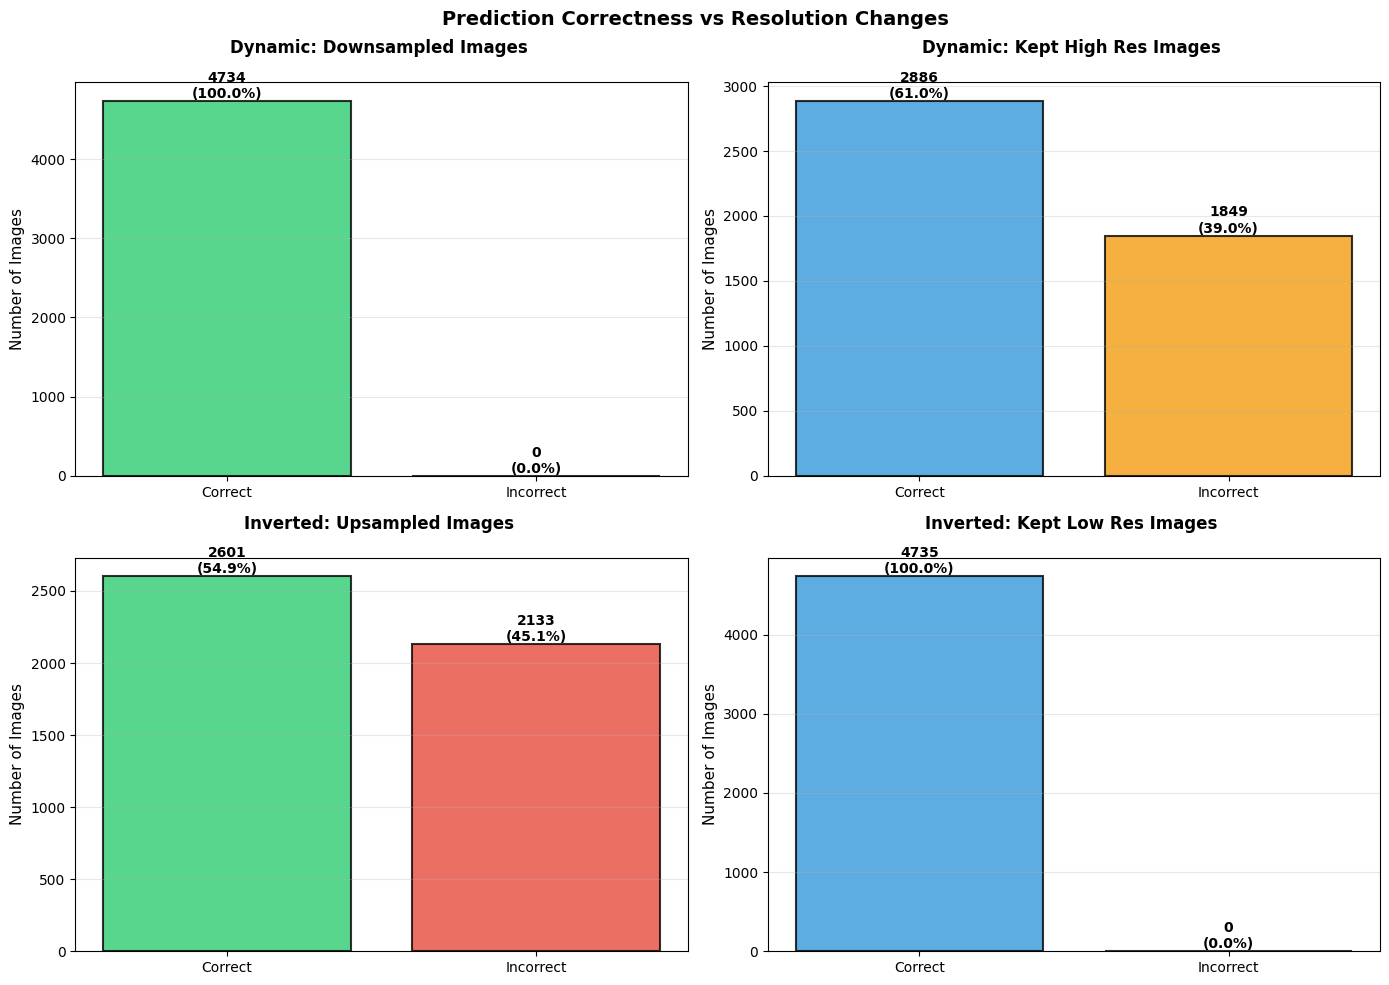

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

correctness_results = [('Dynamic', correctness_dynamic), ('Inverted', correctness_inverted)]

for row_idx, (mode_name, results) in enumerate(correctness_results):
    ax_changed = axes[row_idx, 0]
    ax_unchanged = axes[row_idx, 1]

    action = 'Downsampled' if mode_name == 'Dynamic' else 'Upsampled'
    kept = 'Kept High Res' if mode_name == 'Dynamic' else 'Kept Low Res'

    categories_changed = ['Correct', 'Incorrect']
    counts_changed = [results['changed_correct'], results['changed_incorrect']]
    colors_changed = ['#2ecc71', '#e74c3c']

    bars = ax_changed.bar(categories_changed, counts_changed, color=colors_changed, alpha=0.8, edgecolor='black', linewidth=1.5)

    ax_changed.set_ylabel('Number of Images', fontsize=11)
    ax_changed.set_title(f'{mode_name}: {action} Images \n', fontsize=12, fontweight='bold')
    ax_changed.grid(axis='y', alpha=0.3)

    for bar, count in zip(bars, counts_changed):
        height = bar.get_height()
        pct = (count / results['total_changed']) * 100
        ax_changed.text(bar.get_x() + bar.get_width()/2., height, f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

    categories_unchanged = ['Correct', 'Incorrect']
    counts_unchanged = [results['unchanged_correct'], results['unchanged_incorrect']]
    colors_unchanged = ['#3498db', '#f39c12']

    bars = ax_unchanged.bar(categories_unchanged, counts_unchanged, color=colors_unchanged, alpha=0.8, edgecolor='black', linewidth=1.5)

    ax_unchanged.set_ylabel('Number of Images', fontsize=11)
    ax_unchanged.set_title(f'{mode_name}: {kept} Images \n', fontsize=12, fontweight='bold')
    ax_unchanged.grid(axis='y', alpha=0.3)

    for bar, count in zip(bars, counts_unchanged):
        height = bar.get_height()
        pct = (count / results['total_unchanged']) * 100
        ax_unchanged.text(bar.get_x() + bar.get_width()/2., height, f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Prediction Correctness vs Resolution Changes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()